In [1]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", ".."))
sys.path.append(os.path.join(os.getcwd(), ".."))
sys.path

import pandas as pd
import numpy as np
import os
import re

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
cmap = sns.color_palette("vlag", as_cmap=True)

In [2]:
uniref90_aligned_binary_file_path = os.path.join(os.getcwd(), "..", "..", "..", "..","output/raw/coronaviridae_s_prot_perturbation/20240320/sars-cov-2/analysis/uniref90_aligned_binary.csv")
uniref90_aligned_multi_file_path = os.path.join(os.getcwd(), "..", "..", "..", "..","output/raw/coronaviridae_s_prot_perturbation/20240320/sars-cov-2/analysis/uniref90_aligned_multi.csv")
uniprot_aligned_binary_file_path = os.path.join(os.getcwd(), "..", "..", "..", "..","output/raw/coronaviridae_s_prot_perturbation/20240320/sars-cov-2/analysis/uniprot_aligned_binary.csv")
uniprot_aligned_multi_file_path = os.path.join(os.getcwd(), "..", "..", "..", "..","output/raw/coronaviridae_s_prot_perturbation/20240320/sars-cov-2/analysis/uniprot_aligned_multi.csv")

In [3]:
spike_protein_domain_map = {
    "NTD": [14, 305],
    "S1 Subunit": [14, 685],
    "S2 Subunit": [686, 1273],
    "RBD": [319, 541],
#     "FP": [788, 806],
#     "HR1": [912, 984],
#     "HR2": [1163, 1213]
}


human_label = "Human"
pred_diff_col = f"{human_label}_pred_diff"

def annotate_region(pos, region):
    pos = int(pos)
    start = spike_protein_domain_map[region][0]
    end = spike_protein_domain_map[region][1]
    if (int(pos) >= start and int(pos) <= end):
        return 1
    else:
        return 0

In [4]:
file_paths = [uniref90_aligned_binary_file_path, uniref90_aligned_multi_file_path, uniprot_aligned_binary_file_path, uniprot_aligned_multi_file_path]
dfs = []
for file_path in file_paths:
    df = pd.read_csv(file_path)
    df.rename(columns={"uniref90_id": "id", "uniprot_id": "id"}, inplace=True)
    dfs.append(df[["id", human_label, "y_true", "orig_token", "perturb_seq_pos", "new_token", pred_diff_col, f"abs_{pred_diff_col}", "perturb_pos", "experiment"]])
df = pd.concat(dfs)
df = df[~df["perturb_seq_pos"].isna()]
df.shape

(13162, 10)

In [5]:
df["perturb_seq_pos"] = df["perturb_seq_pos"].astype("Int64")
df["perturbation_id"] = df.apply(lambda x: f"{x['perturb_seq_pos']}_{x['new_token']}", axis=1)
df.columns

Index(['id', 'Human', 'y_true', 'orig_token', 'perturb_seq_pos', 'new_token',
       'Human_pred_diff', 'abs_Human_pred_diff', 'perturb_pos', 'experiment',
       'perturbation_id'],
      dtype='object')

In [6]:
df.head()

,id,Human,y_true,orig_token,perturb_seq_pos,new_token,Human_pred_diff,abs_Human_pred_diff,perturb_pos,experiment,perturbation_id
0,UniRef90_A0A8B6RAI1,0.590175,Human,I,402,L,-0.397972,0.397972,1069,sarscov2-uniref90-aligned-binary,402_L
1,UniRef90_A0A8B6RAI1,0.571952,Human,V,401,L,-0.416195,0.416195,1068,sarscov2-uniref90-aligned-binary,401_L
2,UniRef90_A0A8B6RAI1,0.863793,Human,Q,409,L,-0.124355,0.124355,1076,sarscov2-uniref90-aligned-binary,409_L
3,UniRef90_A0A8B6RAI1,0.741563,Human,R,403,L,-0.246585,0.246585,1070,sarscov2-uniref90-aligned-binary,403_L
4,UniRef90_A0A8B6RJG7,0.852662,Human,Q,409,L,-0.135195,0.135195,1076,sarscov2-uniref90-aligned-binary,409_L


In [7]:
len(df["perturb_seq_pos"].unique())

194

In [8]:
experiment_counts = df["experiment"].value_counts().to_dict()
experiment_counts

{'sarscov2-uniprot-aligned-multi': 9305,
 'sarscov2-uniref90-aligned-multi': 3139,
 'sarscov2-uniprot-aligned-binary': 417,
 'sarscov2-uniref90-aligned-binary': 301}

In [9]:
df_1 = df[["id", "perturb_seq_pos", "experiment"]].groupby(["perturb_seq_pos", "experiment"]).count()
df_1 = df_1.reset_index()
df_1["proportion"] = df_1.apply(lambda x: x["id"]/experiment_counts[x["experiment"]], axis=1)
 
df_1_pivot = df_1.pivot(columns="experiment", index="perturb_seq_pos", values="proportion")
df_1_pivot

experiment,sarscov2-uniprot-aligned-binary,sarscov2-uniprot-aligned-multi,sarscov2-uniref90-aligned-binary,sarscov2-uniref90-aligned-multi
perturb_seq_pos,,,,
1,NaN,NaN,NaN,0.000319
2,NaN,NaN,NaN,0.005734
3,NaN,NaN,NaN,0.007646
4,NaN,NaN,NaN,0.019433
5,NaN,NaN,NaN,0.016247
...,...,...,...,...
584,NaN,0.016013,NaN,NaN
586,NaN,0.012896,NaN,NaN
596,NaN,0.022246,NaN,NaN


In [10]:
# df_2 = df[["Human_pred_diff", "perturb_seq_pos", "experiment"]].groupby(["perturb_seq_pos", "experiment"])["Human_pred_diff"].agg(Max = "max", Mean = "mean")
# df_2 = df_2.reset_index()
# df_2_pivot_mean = df_2.pivot(index="perturb_seq_pos", columns="experiment", values="Mean")
# df_2_pivot_max = df_2.pivot(index="perturb_seq_pos", columns="experiment", values="Max")

In [11]:
df_2 = df[["Human_pred_diff", "perturb_seq_pos"]].groupby(["perturb_seq_pos"])["Human_pred_diff"].agg(Max_Pred_Diff = "max", Mean_Pred_Diff = "mean")
df_2 = df_2.reset_index()
df_2 = df_2.set_index("perturb_seq_pos")
#df_2_pivot_mean = df_2.pivot(index="perturb_seq_pos", columns="experiment", values="Mean")
#df_2_pivot_max = df_2.pivot(index="perturb_seq_pos", columns="experiment", values="Max")

In [20]:
n = df.shape[0]
df_3 = df["perturb_seq_pos"].value_counts().reset_index()
df_3.rename(columns={"index": "seq_pos", "perturb_seq_pos": "count"}, inplace=True)
df_3 = df_3.sort_values("seq_pos")
for k in list(spike_protein_domain_map.keys()):
   df_3[k] = df_3.apply(lambda x: annotate_region(x["seq_pos"], k), axis=1)
# #df_3 = df_3[list(spike_protein_domain_map.keys()]
# #df_3["RBD"] = df_3.apply(lambda x: annotate_region(x["perturb_seq_pos"], "RBD"), axis=1)

# for k in list(spike_protein_domain_map.keys()):
#    df_3[k] = df_3.apply(lambda x: x["count"]/n, axis=1)
df_3 = df_3.drop(columns="count").set_index("seq_pos")

194


,NTD,S1 Subunit,S2 Subunit,RBD
seq_pos,,,,
1,0,0,0,0
2,0,0,0,0
3,0,0,0,0
4,0,0,0,0
5,0,0,0,0
...,...,...,...,...
494,0,1,0,1
496,0,1,0,1
498,0,1,0,1


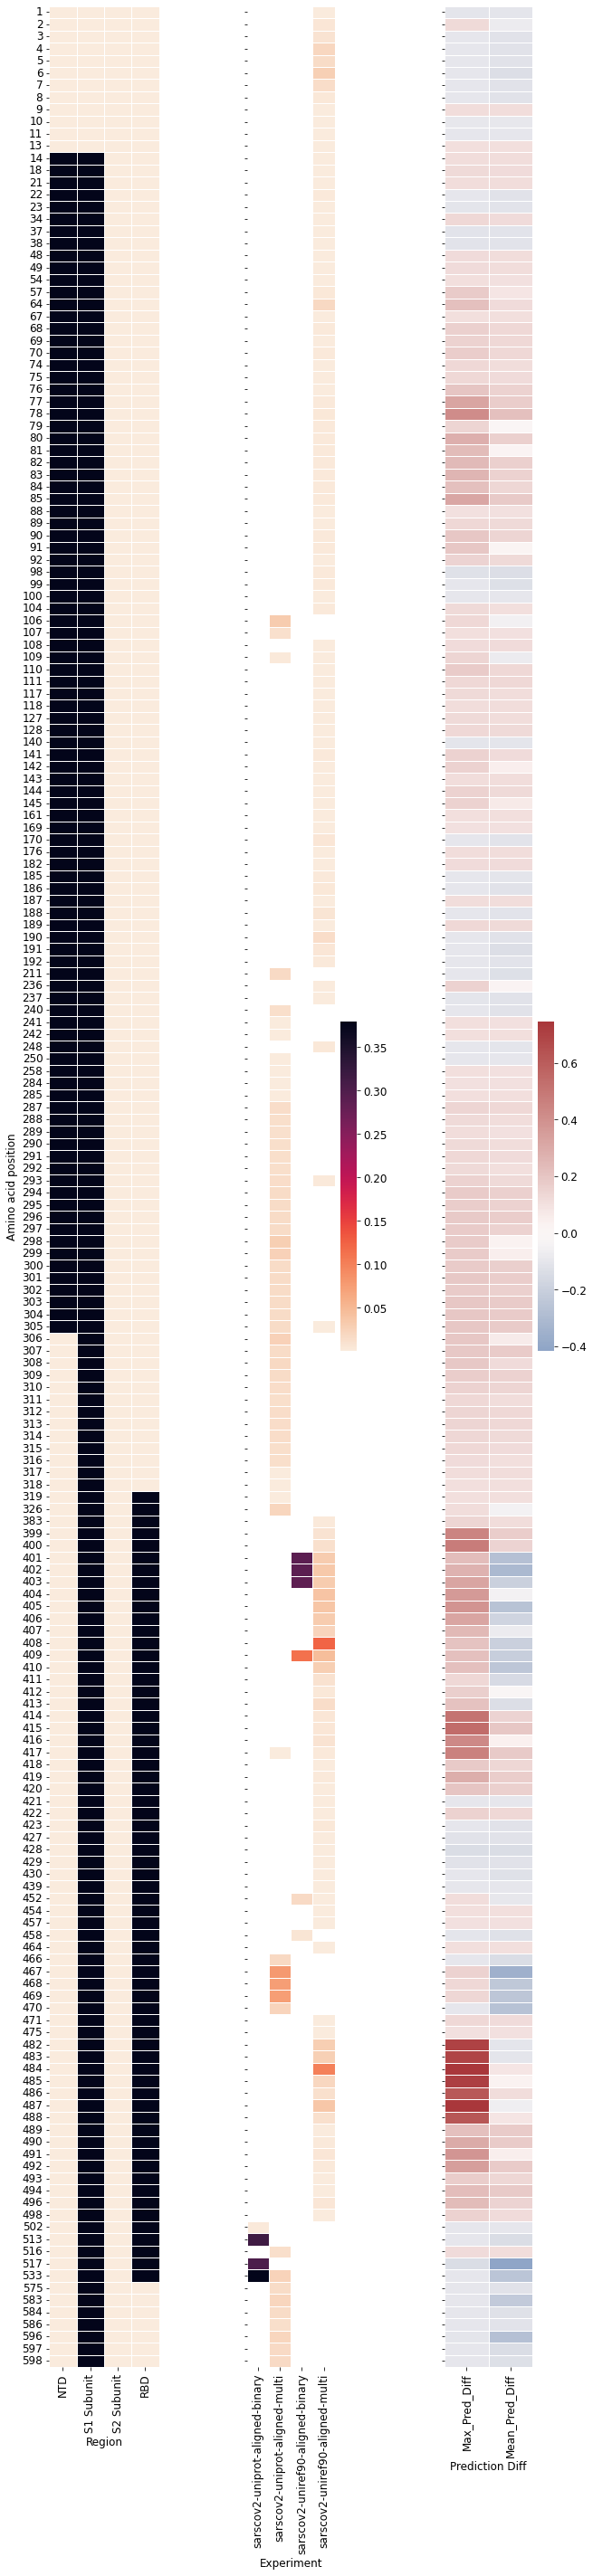

In [13]:
output_file_path = os.path.join(os.getcwd(), "..", "..", "..", "..", "output/visualization/prelim_exam/sarscov2_s_uniref90_uniprot_aligned_perturbation_analysis_vertical.pdf")
cmap = sns.color_palette("vlag", as_cmap=True)
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams.update({'font.size': 12})
fig, ax =plt.subplots(1,3,figsize=(10, 48), sharey=True, gridspec_kw={'width_ratios': [1, 1, 1]})
sns.heatmap(df_3, linewidth=.5, ax=ax[0], vmin=0, vmax=1, cmap=sns.cm.rocket_r, cbar=False)
ax[0].set_xlabel("Region")
ax[0].set_ylabel("Amino acid position")
sns.heatmap(df_1_pivot, linewidth=.5, ax=ax[1], cmap=sns.cm.rocket_r)
ax[1].set_xlabel("Experiment")
ax[1].set_ylabel("")
sns.heatmap(df_2, linewidth=.5, ax=ax[2], cmap=cmap, center=0)
ax[2].set_xlabel("Prediction Diff")
ax[2].set_ylabel("")
# sns.heatmap(df_2_pivot_max, linewidth=.5, ax=ax[2])
#ax[2].set_xlabel("Prediction Diff", 12)
#ax[2].set_ylabel("")

#ax[1].legend(loc='right', bbox_to_anchor=(1.0, 1.05))
#fig.tight_layout(pad=5.0)
plt.subplots_adjust(wspace=.8)
#ax[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize="10")
plt.savefig(output_file_path)
plt.show()

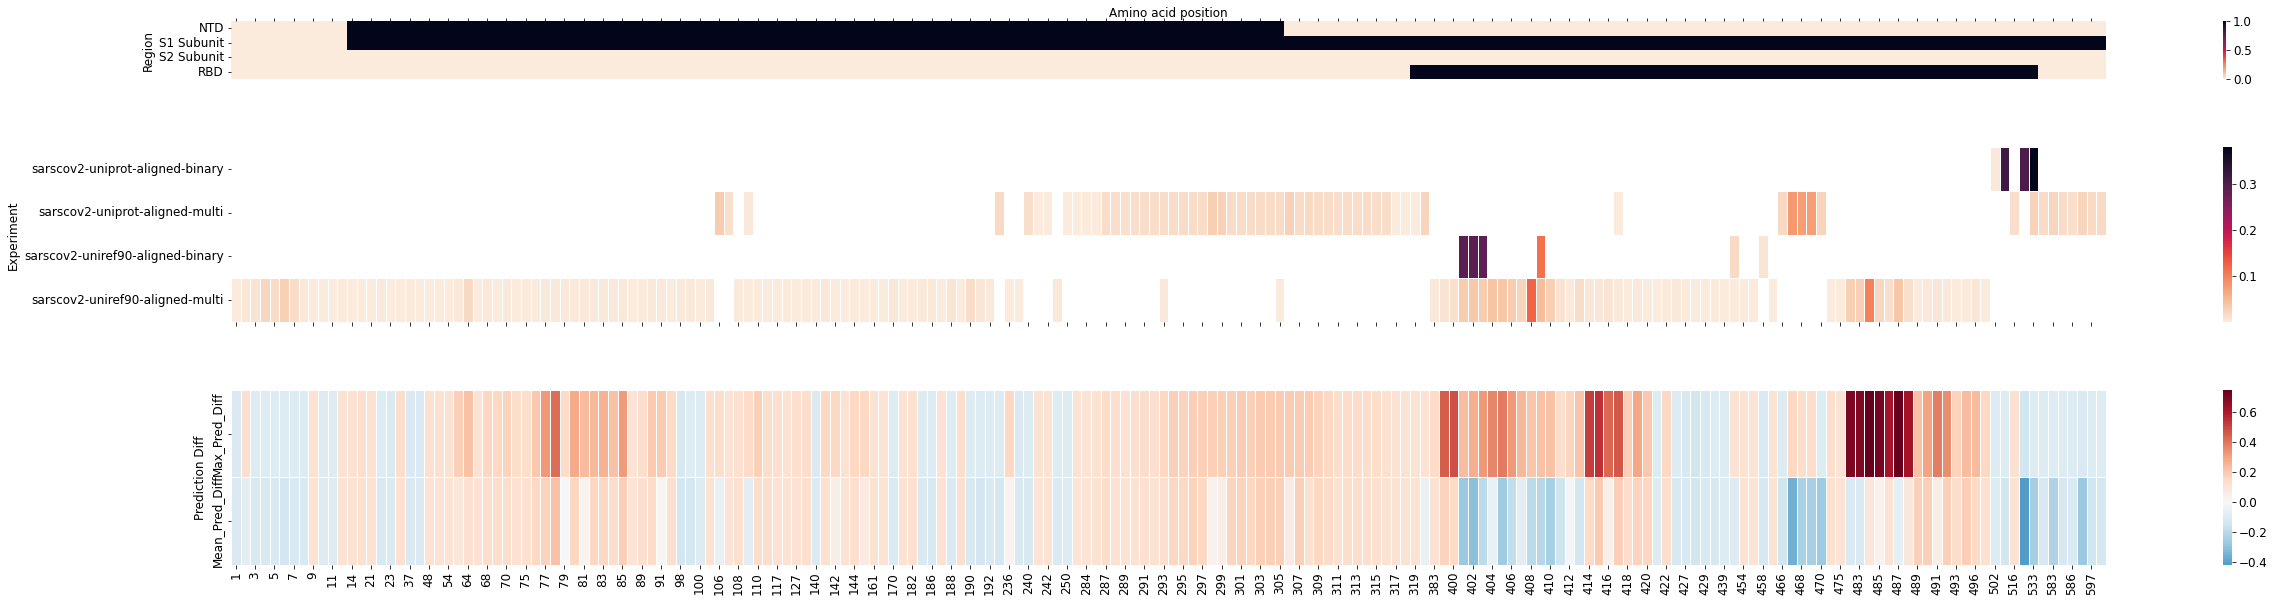

In [14]:
output_file_path = os.path.join(os.getcwd(), "..", "..", "..", "..", "output/visualization/prelim_exam/sarscov2_s_uniref90_uniprot_aligned_perturbation_analysis_horizontal.pdf")
cmap = sns.color_palette("vlag", as_cmap=True)
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams.update({'font.size': 12})
fig, ax =plt.subplots(3,1,figsize=(42, 10), sharex=True, gridspec_kw={'height_ratios': [.5, 1.5, 1.5]})

sns.heatmap(df_3.T, ax=ax[0], vmin=0, vmax=1, cmap=sns.cm.rocket_r, cbar=True)
ax[0].set_ylabel("Region")
ax[0].set_xlabel("Amino acid position")
ax[0].xaxis.tick_top()
ax[0].xaxis.set_label_position("top")

sns.heatmap(df_1_pivot.T, linewidth=.5, ax=ax[1], cmap=sns.cm.rocket_r)
ax[1].set_ylabel("Experiment")
ax[1].set_xlabel("")

sns.heatmap(df_2.T, linewidth=.5, ax=ax[2], cmap="RdBu_r", center=0)
ax[2].set_ylabel("Prediction Diff")
ax[2].set_xlabel("")

# sns.heatmap(df_2_pivot_max, linewidth=.5, ax=ax[2])
#ax[2].set_xlabel("Prediction Diff", 12)
#ax[2].set_ylabel("")

#ax[1].legend(loc='right', bbox_to_anchor=(1.0, 1.05))
#fig.tight_layout(pad=5.0)
plt.subplots_adjust(hspace=.5)
#ax[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize="10")
plt.savefig(output_file_path)
plt.show()